In [15]:
import os
import random
import tarfile

import numpy as np
from six.moves import urllib

In [16]:
PROJECT_ROOT = os.getcwd() 
HOUSING_PATH = os.path.join(PROJECT_ROOT, "data", "housing")
HOUSING_CSV = os.path.join(PROJECT_ROOT, "housing.csv")

In [17]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [18]:
housing = load_housing_data()
housing.head()

,Location,Price,Price per m2,Size M2,Rooms
0,"Warszawa, Praga-Północ",396 000 zł,13 655 zł/m²,29 m²,2 pokoje
1,"Warszawa, Bemowo, ul. Secemińska",695 000 zł,11 564 zł/m²,60.1 m²,3 pokoje
2,"Warszawa, Wilanów",828 000 zł,15 055 zł/m²,55 m²,2 pokoje
3,"Warszawa, Białołęka",730 000 zł,13 225 zł/m²,55.2 m²,3 pokoje
4,"Warszawa, Śródmieście, ul. Marszałkowska 111a",750 000 zł,19 330 zł/m²,38.8 m²,2 pokoje


In [20]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11250 entries, 0 to 11249
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Location      11250 non-null  object
 1   Price         11250 non-null  object
 2   Price per m2  11250 non-null  object
 3   Size M2       11250 non-null  object
 4   Rooms         11250 non-null  object
dtypes: object(5)
memory usage: 439.6+ KB


In [22]:
housing['Location'].value_counts()

Location
Warszawa, Mokotów                                       301
Warszawa, Śródmieście                                   253
Warszawa, Wola                                          212
Warszawa, Praga-Południe                                181
Warszawa, Ursynów                                       165
                                                       ... 
Warszawa, Śródmieście, Natolińska                         1
Warszawa, Włochy, Potrzebna                               1
Warszawa, Wola, Moczydło, Monte Cassino                   1
Warszawa, Śródmieście, Nowe Miasto, ul. Świętojerska      1
Warszawa, Śródmieście, Traugutta                          1
Name: count, Length: 3906, dtype: int64

In [23]:
housing.describe()

,Location,Price,Price per m2,Size M2,Rooms
count,11250,11250,11250,11250,11250
unique,3906,1890,5783,2810,10
top,"Warszawa, Mokotów",599 000 zł,10 000 zł/m²,48 m²,2 pokoje
freq,301,178,67,211,4365


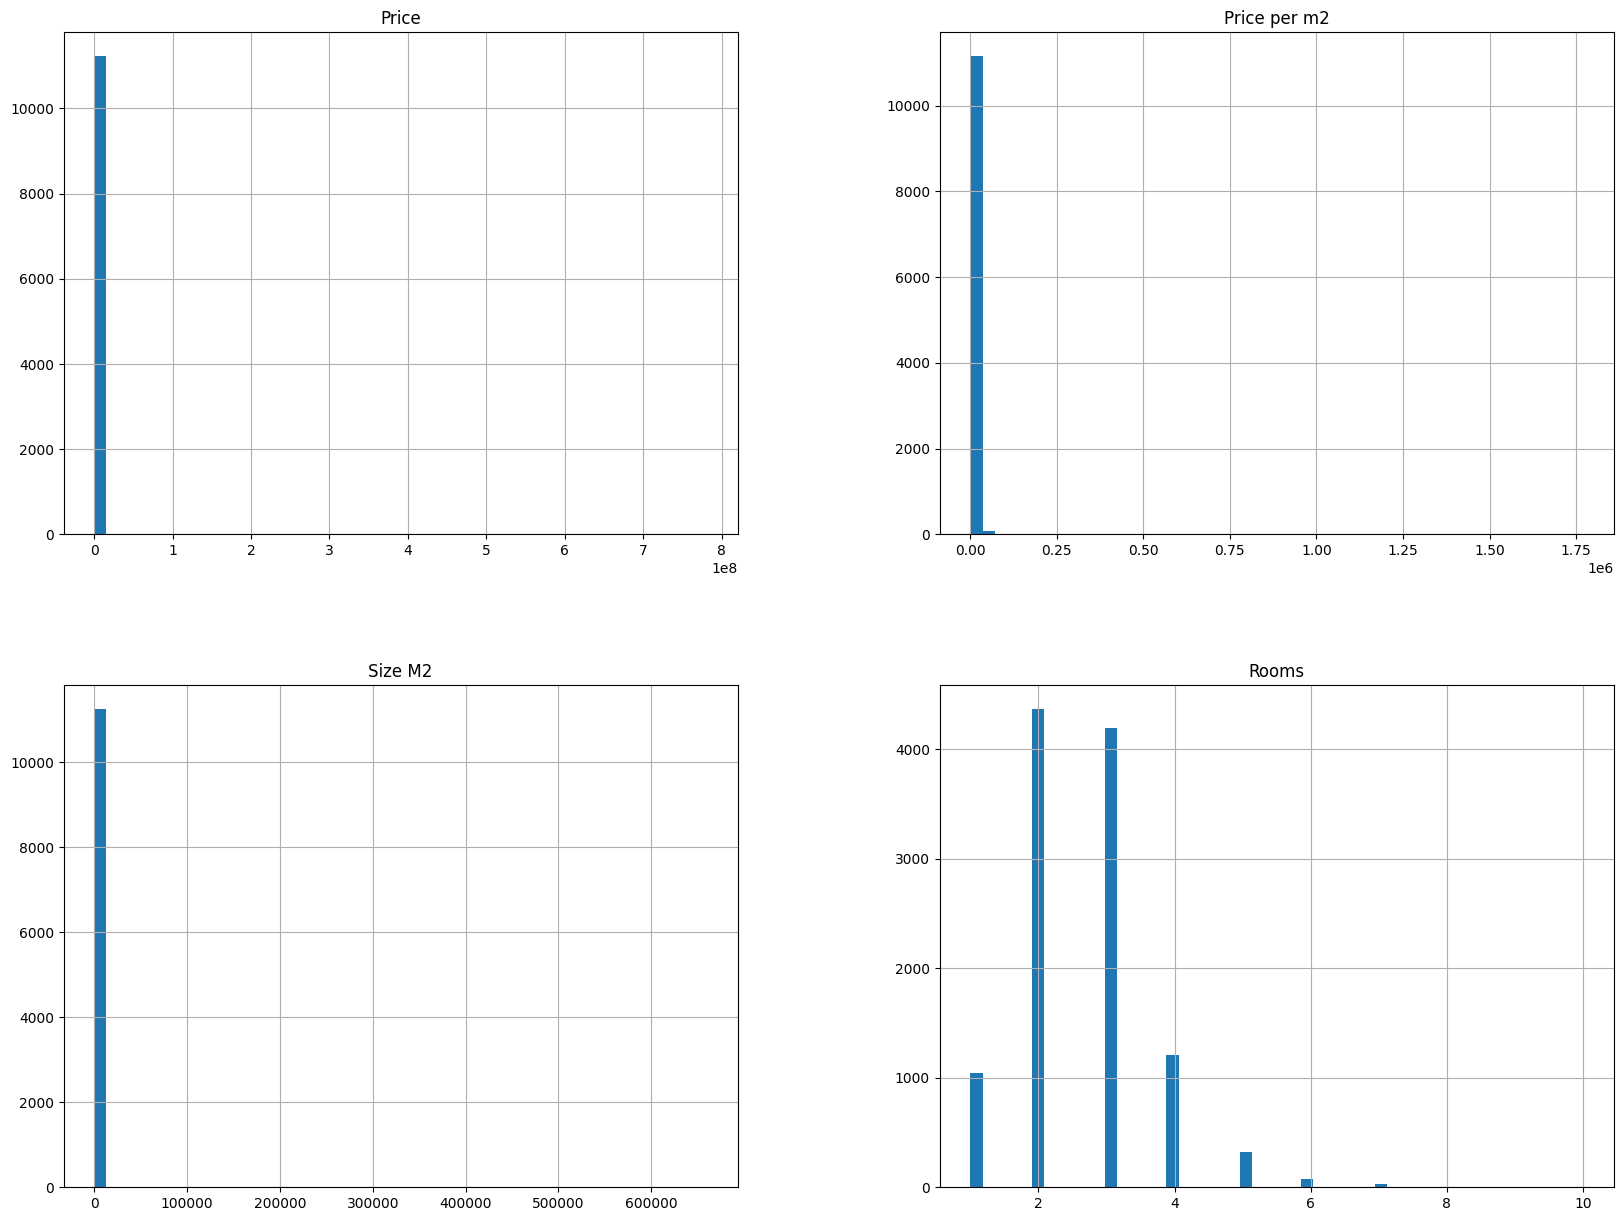

In [28]:
import matplotlib_inline
import matplotlib.pyplot as plt
housing["Price"] = housing["Price"].astype(str)

# Remove spaces, currency symbols (€ and zł), and commas
housing["Price"] = (
    housing["Price"]
    .str.replace(r"[^\d.]", "", regex=True)
    .astype(float)  # Convert to float
)

# Fix 'Price per m2'
housing["Price per m2"] = (
    housing["Price per m2"]
    .astype(str)
    .str.replace(r"[^\d.]", "", regex=True)
    .astype(float)
)

# Fix 'Size M2'
housing["Size M2"] = (
    housing["Size M2"]
    .astype(str)
    .str.replace(r"[^\d.]", "", regex=True)
    .astype(float)
)

# Fix 'Rooms' (extract only numbers)
housing["Rooms"] = (
    housing["Rooms"]
    .astype(str)
    .str.extract(r"(\d+)") 
    .astype(float)
)

housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [30]:
import numpy as np

def split_train_test(data, test_ratio):
    random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print("Learning: ", len(train_set), "Training: ", len(train_set), "Testing: ", len(test_set))

Learning:  9000 Training:  9000 Testing:  2250


In [31]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_col, hash=hashlib.md5):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print("Learning: ", len(train_set), "Training: ", len(train_set), "Testing: ", len(test_set))

Learning:  8977 Training:  8977 Testing:  2273


In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["Rooms"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print("Training set distribution:\n", strat_train_set["Rooms"].value_counts() / len(strat_train_set))
print("Test set distribution:\n", strat_test_set["Rooms"].value_counts() / len(strat_test_set))

housing = strat_train_set.copy()

Training set distribution:
 Rooms
2.0     0.388000
3.0     0.372667
4.0     0.107222
1.0     0.092889
5.0     0.028889
6.0     0.006778
7.0     0.002667
8.0     0.000444
10.0    0.000444
Name: count, dtype: float64
Test set distribution:
 Rooms
2.0     0.388000
3.0     0.372444
4.0     0.107556
1.0     0.092889
5.0     0.028889
6.0     0.006667
7.0     0.002667
8.0     0.000444
10.0    0.000444
Name: count, dtype: float64


In [74]:
import ssl
import certifi
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter


# Ensure the correct CA bundle is used
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# Filter for Warsaw properties (make sure the 'housing' DataFrame exists)
housing_warsaw = housing[housing["Location"].str.contains("Warszawa", case=False, na=False)].copy()

# Initialize the geolocator with a descriptive user agent per Nominatim's usage policy
geolocator = Nominatim(user_agent="MyApp/1.0 (my_email@example.com)")
# Use a rate limiter to prevent exceeding request limits (minimum 1 second between calls)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def format_address(address):
    if "Warszawa" not in address:
        return f"Warszawa, {address}"
    return address

housing_warsaw["Formatted_Address"] = housing_warsaw["Location"].apply(format_address)

# Get the unique formatted addresses to avoid duplicate geocoding calls
unique_addresses = housing_warsaw["Formatted_Address"].unique()

# Create a dictionary to cache geocoding results
geocode_cache = {}

for addr in unique_addresses:
    try:
        location = geocode(addr, timeout=10)
        if location:
            geocode_cache[addr] = (location.latitude, location.longitude)
        else:
            geocode_cache[addr] = (None, None)
    except GeocoderTimedOut:
        geocode_cache[addr] = (None, None)

# Map the cached geocoding results back to the DataFrame
housing_warsaw["Latitude"] = housing_warsaw["Formatted_Address"].map(lambda addr: geocode_cache.get(addr)[0])
housing_warsaw["Longitude"] = housing_warsaw["Formatted_Address"].map(lambda addr: geocode_cache.get(addr)[1])

housing_warsaw.drop(columns=["Formatted_Address"], inplace=True)

housing_warsaw.to_csv("housing_warsaw_with_coordinates.csv", index=False)

housing_warsaw.head()


,Location,Price,Price per m2,Size M2,Rooms,Latitude,Longitude
5062,"Warszawa, Ursynów",950000.0,18269.0,52.0,3.0,52.141039,21.032321
9706,"Warszawa, Śródmieście, Nowe Miasto",636400.0,17200.0,37.0,2.0,52.252944,21.008331
4020,"Warszawa, Wola, ul. Żelazna",1250000.0,10870.0,115.0,6.0,52.232063,20.992241
7922,"Warszawa, Białołęka",350000.0,9722.0,36.0,2.0,52.331566,21.020619
2786,"Warszawa, Ursynów, ul. Belgradzka",958200.0,12396.0,77.3,3.0,NaN,NaN


In [45]:
"""
total_addresses = housing_warsaw.shape[0]
print(f"Total addresses to geocode: {total_addresses}")
"""

Total addresses to geocode: 9000


In [75]:
housing_warsaw.describe()

,Price,Price per m2,Size M2,Rooms,Latitude,Longitude
count,9.000000e+03,9.000000e+03,9000.000000,9000.000000,7236.000000,7236.000000
mean,1.250983e+06,1.553409e+04,62.656090,2.627556,52.228284,21.011115
std,1.123421e+07,3.585710e+04,36.334357,0.990092,0.048007,0.063654
min,5.900000e+03,7.600000e+01,10.000000,1.000000,50.880276,20.650496
25%,5.500000e+05,1.139475e+04,43.000000,2.000000,52.196098,20.964812
50%,6.960000e+05,1.340050e+04,54.000000,3.000000,52.232810,21.018375
75%,9.584000e+05,1.615600e+04,69.412500,3.000000,52.251794,21.052583
max,7.812688e+08,1.769912e+06,560.000000,10.000000,52.361425,21.252281


<Axes: xlabel='Latitude', ylabel='Longitude'>

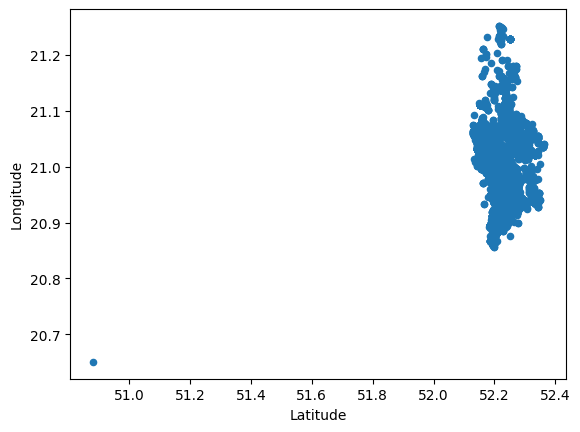

In [76]:
housing_warsaw.plot(kind="scatter", x="Latitude", y="Longitude")

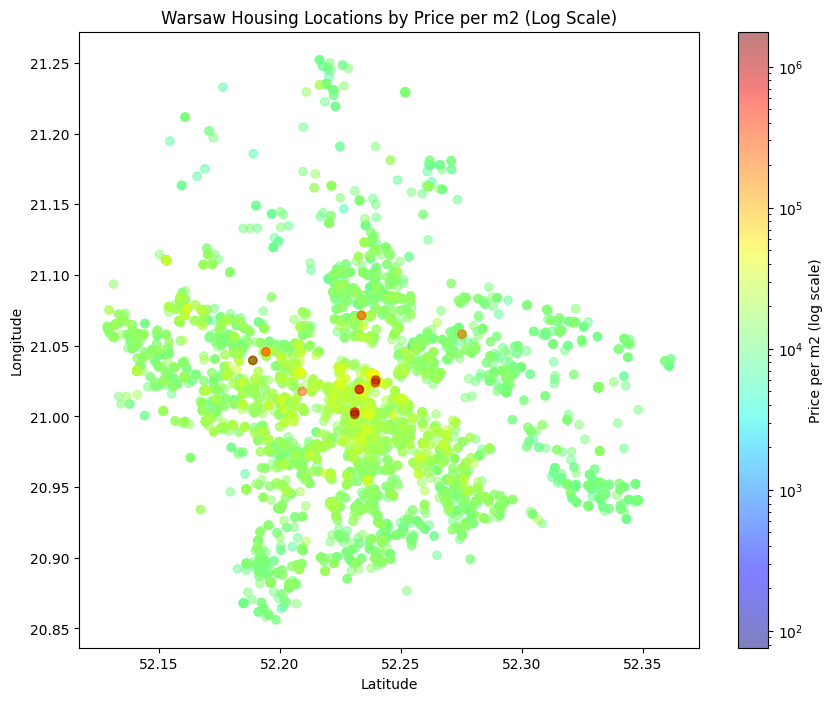

In [101]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Define a bounding box for Warsaw (adjust these values to your preference)
min_lat, max_lat = 52.0, 52.5
min_lon, max_lon = 20.8, 21.3


# Create a boolean mask to filter out points outside this range
geo_mask = (
    (housing_warsaw["Latitude"] >= min_lat) &
    (housing_warsaw["Latitude"] <= max_lat) &
    (housing_warsaw["Longitude"] >= min_lon) &
    (housing_warsaw["Longitude"] <= max_lon)
)

# Optionally, filter out extremely high "Price per m2" outliers.
# Below, we remove prices above (max_price - 75000).
# Adjust this logic to suit your data (e.g., use a percentile cutoff or std-based filter).
price_cutoff = housing_warsaw["Price per m2"].max() #- 75000
price_mask = housing_warsaw["Price per m2"] <= price_cutoff

mask = geo_mask & price_mask
housing_warsaw_filtered = housing_warsaw[mask].copy()
housing_warsaw_sorted = housing_warsaw_filtered.sort_values(by="Price per m2", ascending=True)

price_min = housing_warsaw["Price per m2"].min()
price_max = housing_warsaw["Price per m2"].max()


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    housing_warsaw_sorted["Latitude"],
    housing_warsaw_sorted["Longitude"],
    alpha=0.5,
    c=housing_warsaw_sorted["Price per m2"],
    cmap="jet",  
    norm=mpl.colors.LogNorm(vmin=price_min, vmax=price_max)  # Log scale
)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Warsaw Housing Locations by Price per m2 (Log Scale)")
plt.colorbar(scatter, label="Price per m2 (log scale)")
plt.show()

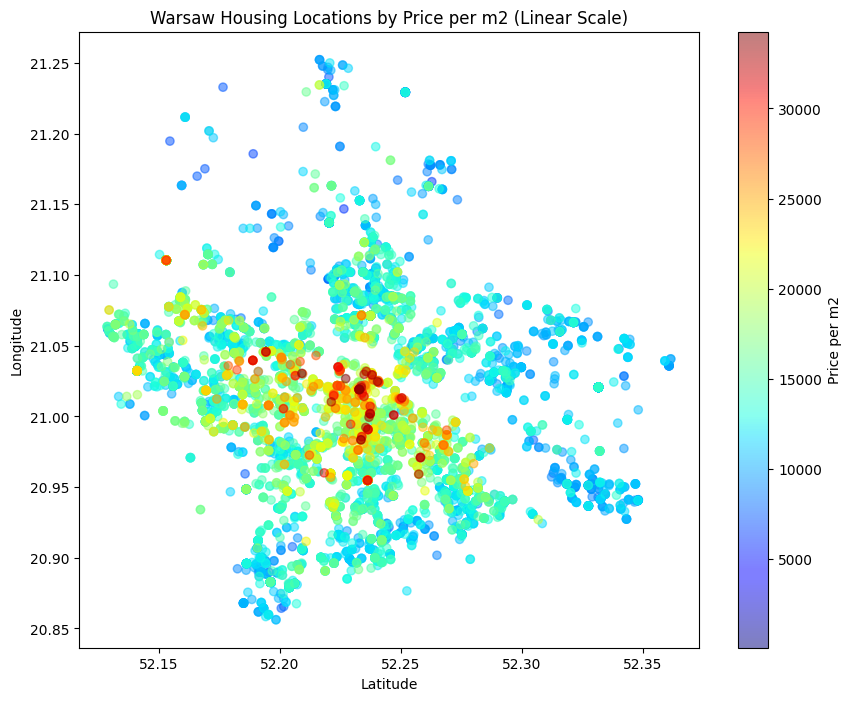

In [118]:
import matplotlib.pyplot as plt

# Sort so higher prices are drawn last
housing_warsaw_sorted = housing_warsaw_filtered.sort_values(by="Price per m2", ascending=True)

price_min = housing_warsaw_sorted["Price per m2"].min()
price_max = housing_warsaw_sorted["Price per m2"].max()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    housing_warsaw_sorted["Latitude"],
    housing_warsaw_sorted["Longitude"],
    alpha=0.5,
    c=housing_warsaw_sorted["Price per m2"],
    cmap=plt.get_cmap("jet"),    
    
    vmin=price_min,  
    vmax=price_max   
)

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Warsaw Housing Locations by Price per m2 (Linear Scale)")
cbar = plt.colorbar(scatter)
cbar.set_label("Price per m2")
plt.show()

In [121]:
housing_warsaw_sorted["Price per m2"] = pd.to_numeric(
    housing_warsaw_sorted["Price per m2"], errors="coerce"
)

numeric_df = housing_warsaw_sorted.select_dtypes(include="number")

corr_matrix = numeric_df.corr()

print(corr_matrix["Price per m2"].sort_values(ascending=False))

Price per m2    1.000000
Size M2         0.127031
Price           0.116442
Longitude      -0.009414
Rooms          -0.050475
Latitude       -0.186987
Name: Price per m2, dtype: float64


array([[<Axes: xlabel='Price', ylabel='Price'>,
        <Axes: xlabel='Price per m2', ylabel='Price'>,
        <Axes: xlabel='Size M2', ylabel='Price'>,
        <Axes: xlabel='Rooms', ylabel='Price'>,
        <Axes: xlabel='Latitude', ylabel='Price'>,
        <Axes: xlabel='Longitude', ylabel='Price'>],
       [<Axes: xlabel='Price', ylabel='Price per m2'>,
        <Axes: xlabel='Price per m2', ylabel='Price per m2'>,
        <Axes: xlabel='Size M2', ylabel='Price per m2'>,
        <Axes: xlabel='Rooms', ylabel='Price per m2'>,
        <Axes: xlabel='Latitude', ylabel='Price per m2'>,
        <Axes: xlabel='Longitude', ylabel='Price per m2'>],
       [<Axes: xlabel='Price', ylabel='Size M2'>,
        <Axes: xlabel='Price per m2', ylabel='Size M2'>,
        <Axes: xlabel='Size M2', ylabel='Size M2'>,
        <Axes: xlabel='Rooms', ylabel='Size M2'>,
        <Axes: xlabel='Latitude', ylabel='Size M2'>,
        <Axes: xlabel='Longitude', ylabel='Size M2'>],
       [<Axes: xlabel='Price', 

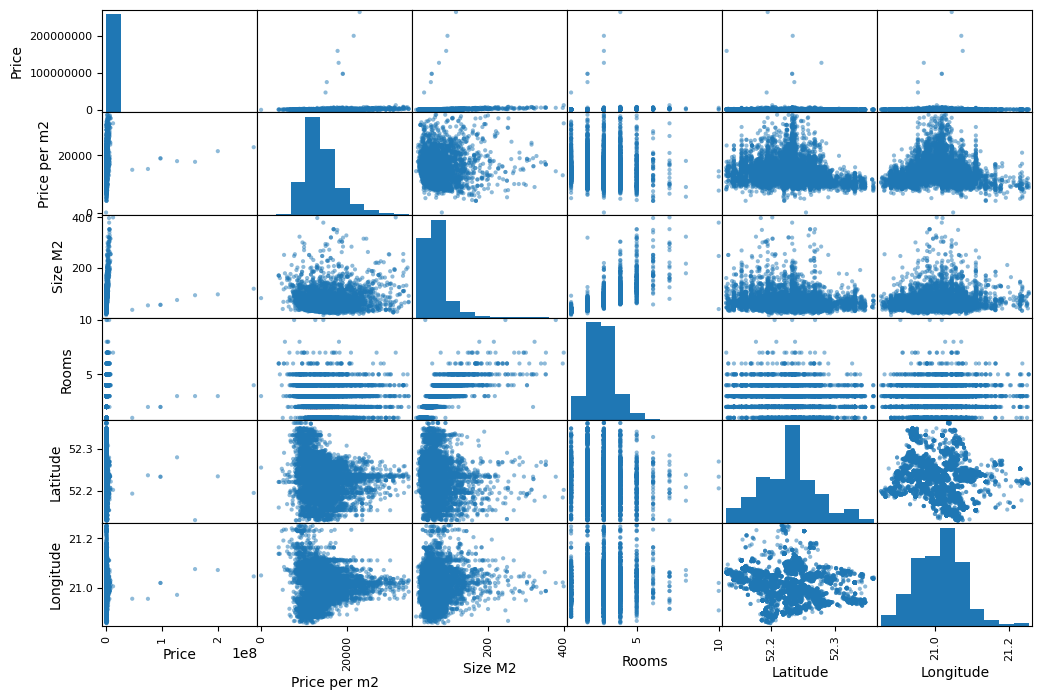

In [123]:
from pandas.plotting import scatter_matrix

attributes = ["Location", "Price","Price per m2","Size M2","Rooms","Latitude","Longitude"]
scatter_matrix(housing_warsaw_sorted[attributes], figsize=(12, 8))

In [ ]:
housing = strat_train_set.drop("Price per m2", axis=1)
housing_labels = strat_train_set["Price per m2"].copy()
